In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import gc 
gc.collect()

9

# LOAD DATA

In [2]:
train_df = pd.read_csv('Train_Product_Data_2021_0114.csv',index_col=0)
train_df.head(3)

,string_X_train,string_Y_1,string_Y_2,Y_label,Forward,Backward,row_id,label_for_train
586,"YUNGSOX 2100M 12MT USD1,015/MT USD12,180 YUNGS...",0,13,YUNGSOX 2100M,NaN,"2MT USD1,015",855,"{'Product':[( 0 , 13 )]}"
92,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",0,50,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",CLOHEXANE DI,"OXYLIC ACID,",140,"{'Product':[( 0 , 50 )]}"
91,"TRIS . CIF PORT KLANG,MALAYSIA",0,4,TRIS,NaN,SIA,139,"{'Product':[( 0 , 4 )]}"


In [3]:
val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0)
val_df.head(3)

,string_X_train,string_Y_1,string_Y_2,Y_label,Forward,Backward,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,NaN,"TITY: 3,000.",1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,NaN,"TITY: 3,000.",2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,NaN,RADE TERMS:,10


# preprocessing

In [4]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# Next, let’s "tokenize" our context/question pairs.

In [5]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [6]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

20

# data is ready. Let’s just put it in a PyTorch dataset

In [7]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

20

# use a DistilBert model with a QA head for training:

In [8]:
from transformers import DistilBertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

223

# train loop

In [9]:
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True)
optim = Adam(model.parameters(), lr = 5e-5 )

def train_step(batch):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optim.step()
    optim.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(batch):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    gc.collect()
    return loss.item()

k = 5
history = {'train_loss':[],'val_loss':[]}
best_loss = np.inf
best_model = None

for epoch in tqdm(range(k)):    
    
    # reset this epoch loss
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    
    # train 1 epoch and get train_loss
    for i,batch in enumerate(tqdm(train_loader)):
        epoch_train_loss += train_step(batch)
    
    # val 1 epoch and get val_loss
    for j,batch in enumerate(tqdm(val_loader)):
        epoch_val_loss += val_step(batch)
    
    # record history
    history['train_loss'].append(epoch_train_loss/i)
    history['val_loss'].append(epoch_val_loss/j)
    
    # print this epoch's infomation
    print(f'epoch:{epoch} train_loss:{epoch_train_loss} val_loss:{epoch_val_loss}')
    
    # save best_model
    if history['val_loss'][-1] <= best_loss: 
        best_model = deepcopy(model.eval())
        best_loss = history['val_loss'][-1]
        print(f'save best_model now_val_best_loss is:{best_loss}')

model = best_model.eval()

cuda


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/55 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/24 [00:00<?, ?it/s]

epoch:0 train_loss:92.82890400290489 val_loss:9.87838600575924
save best_model now_val_best_loss is:0.4294950437286626


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:1 train_loss:23.281837932765484 val_loss:6.188826933503151
save best_model now_val_best_loss is:0.26907943189144135


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:2 train_loss:14.617912121117115 val_loss:5.652802772819996
save best_model now_val_best_loss is:0.24577403360086938


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:3 train_loss:10.329204253852367 val_loss:6.0216472670435905


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:4 train_loss:7.911030380055308 val_loss:7.291205197572708


# loss curve

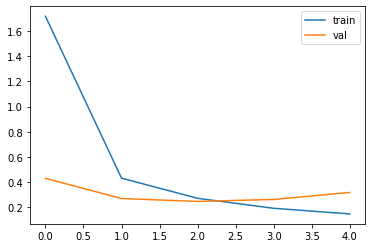

In [35]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# test

In [10]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

In [23]:
def test_model(df,n_test):
    i = 0
    table = pd.DataFrame()
    for _ in tqdm(range(n_test)):
        sample = df.sample(1)
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    display(table)
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [24]:
test_model(val_df,50)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/50 [00:00<?, ?it/s]

,label,predict:,是否全對
0,MALEIC ANHYDRIDE,MALEIC ANHYDRIDE,Yes
1,ETHYLENE-PROPYLENE COPOLYMER,ETHYLENE-PROPYLENE COPOLYMER,Yes
2,EVA TAISOX,EVA TAISOX,Yes
3,HIPS HP8250,GPPS GP5250,No
4,,#NAME?,No
5,TAIRIREX POLYSTYRENE,TAIRIREX POLYSTYRENE,Yes
6,DIETHYLENE GLYCOL DEG,DIETHYLENE GLYCOL DEG,Yes
7,COPOLYMER PROPYLENE,COPOLYMER PROPYLENE,Yes
8,POLYESTER STAPLE FIBER,POLYESTER STAPLE FIBER,Yes
9,HDPE TAISOX 9001,HDPE TAISOX 9001,Yes


,label,predict:,是否全對
0,MALEIC ANHYDRIDE,MALEIC ANHYDRIDE,Yes
1,ETHYLENE-PROPYLENE COPOLYMER,ETHYLENE-PROPYLENE COPOLYMER,Yes
2,EVA TAISOX,EVA TAISOX,Yes
3,HIPS HP8250,GPPS GP5250,No
4,,#NAME?,No
5,TAIRIREX POLYSTYRENE,TAIRIREX POLYSTYRENE,Yes
6,DIETHYLENE GLYCOL DEG,DIETHYLENE GLYCOL DEG,Yes
7,COPOLYMER PROPYLENE,COPOLYMER PROPYLENE,Yes
8,POLYESTER STAPLE FIBER,POLYESTER STAPLE FIBER,Yes
9,HDPE TAISOX 9001,HDPE TAISOX 9001,Yes


# 量化表現

In [25]:
all_res = test_model(val_df,len(val_df))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/744 [00:00<?, ?it/s]

,label,predict:,是否全對
0,ABS RESIN,ABS RESIN,Yes
1,METHYL METHACRYLATE MONOMER,METHYL METHACRYLATE MONOMER,Yes
2,TAIRIREX POLYSTYRENE,nTAIRIREX POLYSTYRENE,No
3,MONOETHYLENE GLYCOL MEG,MONOETHYLENE GLYCOL,No
4,BISPHENOL-A,BISPHENOL-A,Yes
...,...,...,...
739,ETHYLENE-PROPYLENE COPOLYMER,ETHYLENE-PROPYLENE COPOLYMER,Yes
740,GPPS GP550N,GPPS GP550N,Yes
741,HIGH IMPACT POLYSTYRENE,HIGH IMPACT POLYSTYRENE HP8250,No
742,ACRYLONITRILE BUTADIENE STYRENE RESIN,ACRYLONITRILE BUTADIENE STYRENE RESIN,Yes


In [26]:
all_res['是否全對'].value_counts()

Yes    605
No     139
Name: 是否全對, dtype: int64

In [29]:
acc = all_res['是否全對'].value_counts()['Yes']/len(val_df)
acc

0.8131720430107527